In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

In [ ]:
# csv dosyasını okuyup dataframe haline getiriyorum.

data_path = '/content/drive/MyDrive/full_df.csv'

df = pd.read_csv(data_path)
print('Number of Patients : {}'.format(len(df)))
df.head()

Number of Patients : 6392


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


AxesSubplot(0.08,0.07;0.87x0.81)


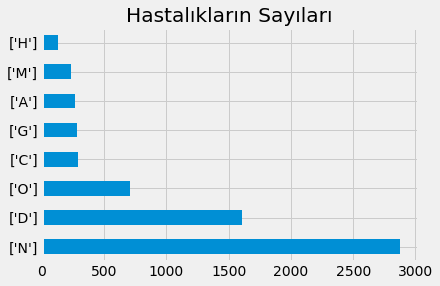

In [ ]:
print(df.labels.value_counts().plot(kind = 'barh', title = 'Hastalıkların Sayıları'))

In [ ]:
# Gereksiz columnları dataframe'den atıyorum

df = df[['ID', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords']]
df.head()

,ID,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,0,0_left.jpg,0_right.jpg,cataract,normal fundus
1,1,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,2,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,4,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,5,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


Hangi gözde hangi hastalığın bulunduğunu Left-Diagnostic Keywords	ve Right-Diagnostic Keywords featureları haricinde bulmak mümkün değildi. Katarakt ve sağlıklı gözleri tespit etmek keywordlerden çok daha kolay çünkü sadece içlerinde 'normal fundus' ve 'cataract' kelimelerinin geçmesi yeterli. Diğer hastalıklarda ise her birini tanımlayan birçok keyword olduğundan dolayı katarakt ve sağlıklı göz için bir binary classification modeli oluşturmaya karar verdim.

In [ ]:
# Katarakt mı yoksa sağlıklı bir göz mü diye ayrım yapabilmek için keywordlere
# bakmak gerekiyor bu amaçla 2 fonksiyon yazıyorum

def is_normal(keywords):
  if "normal fundus" in keywords:
    return True
  else:
    return False

def has_cataract(keywords):
  if "cataract" in keywords:
    return True
  else:
    return False

In [ ]:
# Fonksiyonları ayrı ayrı sağ ve sol göz için yazılmış keywordlere uyguluyorum

df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))

df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
# Katarakt ve sağlıklı göz resimlerinin isimlerini sağ ve sol olmak üzere ayırarak toplamda 4 farklı listeye atıyorum

left_cataract_images, right_cataract_images, left_normal_images, right_normal_images = [], [], [], []

for i in range(len(df)):
  if df["left_cataract"][i] == True:
      left_cataract_images.append(df['Left-Fundus'][i])
  if df["right_cataract"][i] == True:
      right_cataract_images.append(df['Right-Fundus'][i])
  if df["left_normal"][i] == True:
      left_normal_images.append(df['Left-Fundus'][i])
  if df["right_normal"][i] == True:
      right_normal_images.append(df['Right-Fundus'][i])

In [ ]:
# Bu 4 listenin içinde kaçar resim olduğuna bakıyorum

print("Images in left cataract: {}".format(len(left_cataract_images)))
print("Images in right cataract: {}".format(len(right_cataract_images)))
print("Images in left normal: {}".format(len(left_normal_images)))
print("Images in right normal: {}".format(len(right_normal_images)))

Images in left cataract: 304
Images in right cataract: 290
Images in left normal: 2898
Images in right normal: 2777


In [ ]:
# Modelin doğru çalışabilmesi için resim sayılarının birbirine yakın olması gerekiyor
# Bu yüzden sağlıklı göz resimlerinin sayısını katarakt resimlerin sayısıyla eşitliyorum
# ve sampleları random seçiyorum ki rastgele bir dağılım oluşsun.  
# Ve tekrar 4 listede kaçar resim olduğunu kontrol ediyorum.

left_normal_images = random.sample(left_normal_images, 250)
right_normal_images = random.sample(right_normal_images, 250)

print("Images in left cataract: {}".format(len(left_cataract_images)))
print("Images in right cataract: {}".format(len(right_cataract_images)))
print("Images in left normal: {}".format(len(left_normal_images)))
print("Images in right normal: {}".format(len(right_normal_images)))

Images in left cataract: 304
Images in right cataract: 290
Images in left normal: 250
Images in right normal: 250


In [ ]:
# Katarakt ve sağlıklı göz örneklerinin sayıları birbirine eşit oldu sağ ve
# sol göz resimleri de hemen hemen birbirine yakın olduğu için onları değiştirmiyorum 
# ve artık katarakt ve sağlıklı olmak üzere 2 listede bu resimleri birleştiriyorum

normal_image_names = left_normal_images + right_normal_images
cataract_image_names = left_cataract_images + right_cataract_images

print("Normal Images: {}".format(len(normal_image_names)))
print("Cataract Images: {}".format(len(cataract_image_names)))

Normal Images: 500
Cataract Images: 594


In [ ]:
# Resimler isimlerine göre klasörden çekilerek image arrayi oluşturuldu ve 
# karşılığı için label arrayi oluşturuldu dataset train/test için ayrılmaya 
# hazır hale getirildi.

image_size=250

images_path = glob.glob('/content/drive/MyDrive/preprocessed_images/*')

images, labels = [], []

for img in images_path:
  if img[43:] in cataract_image_names:
    image = cv2.imread(img)
    image = cv2.resize(image,(image_size,image_size))
    images.append(image)
    labels.append(1)
  elif img[43:] in normal_image_names:
    image = cv2.imread(img)
    image = cv2.resize(image,(image_size, image_size))
    images.append(image)
    labels.append(0)

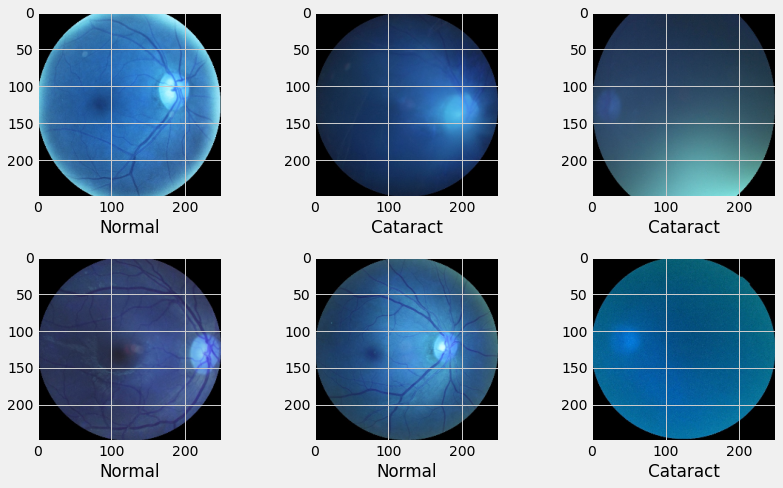

In [ ]:
# Normal ve Katarakt Göz Örnekleri

plt.figure(figsize=(12,7))
for i in range(6):
    sample = random.choice(range(len(images)))
    image = images[sample]
    category = labels[sample]
    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,3,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras import losses, layers, models, optimizers
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Train-Test şeklinde datayı ayırıyorum

images = np.asarray(images)
labels = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size= 0.20, random_state = 33)

In [ ]:
# CNN'in train/validation loss ve accuraccy'lerindeki değişimi 
# görmek amacıyla bir fonksiyon yazıyorum

def plot_history(history, model):
    plt.subplots(figsize=(8, 6))
    plt.subplot(2,1,1) 
    plt.title('Loss')
    plt.plot(history.history['loss'], color='green', alpha = 0.7, label='Train Loss')
    plt.plot(history.history['val_loss'], color='orange', alpha = 0.7, label='Validation Loss')
    plt.legend() 
    plt.subplot(2,1,2) 
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='green', alpha = 0.7, label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', alpha = 0.7, label='Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# VGG16 Modeli

from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(weights="imagenet", include_top = False, input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# Modele flatten ve prediction layer ekliyorum

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
# Model Mimarisi

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Uygun parametrelerle beraber modeli çalıştırıyorum train'in %20 lik 
# kısmını da validation olarak kullanıyorum

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
16/16 [==============================] - 477s 30s/step - loss: 1.6557 - accuracy: 0.8557 - val_loss: 1.8899 - val_accuracy: 0.9024
Epoch 2/10
16/16 [==============================] - 474s 30s/step - loss: 1.1752 - accuracy: 0.9350 - val_loss: 1.8325 - val_accuracy: 0.9024
Epoch 3/10
16/16 [==============================] - 471s 30s/step - loss: 0.4547 - accuracy: 0.9634 - val_loss: 1.4233 - val_accuracy: 0.8862
Epoch 4/10
16/16 [==============================] - 472s 30s/step - loss: 0.0764 - accuracy: 0.9858 - val_loss: 1.3362 - val_accuracy: 0.9106
Epoch 5/10
16/16 [==============================] - 471s 30s/step - loss: 0.0395 - accuracy: 0.9837 - val_loss: 1.2788 - val_accuracy: 0.9024
Epoch 6/10
16/16 [==============================] - 471s 30s/step - loss: 0.0015 - accuracy: 0.9980 - val_loss: 1.1771 - val_accuracy: 0.9106
Epoch 7/10
16/16 [==============================] - 471s 30s/step - loss: 2.0180e-04 - accuracy: 1.0000 - val_loss: 1.1673 - val_accuracy: 0.8943
Ep

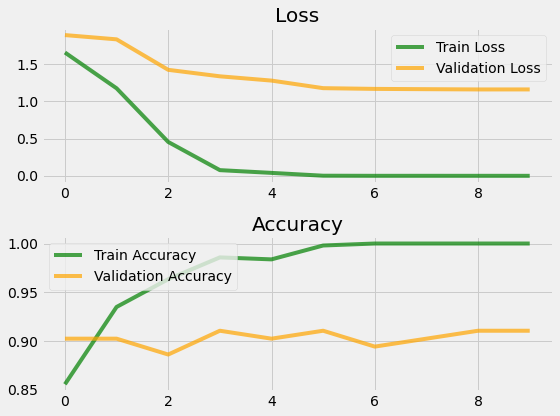

In [ ]:
# train/validation loss ve accuraccy'lerindeki değişim

plot_history(history, model)

In [ ]:
# Modelin test verisiyle accuracy ve loss değerleri

loss, accuracy = model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",accuracy)

5/5 [==============================] - 118s 23s/step - loss: 1.0567 - accuracy: 0.9221
Test Loss: 1.0566635131835938
Test Accuracy: 0.9220778942108154


In [ ]:
# Confusion Matrix oluşturuyorum

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

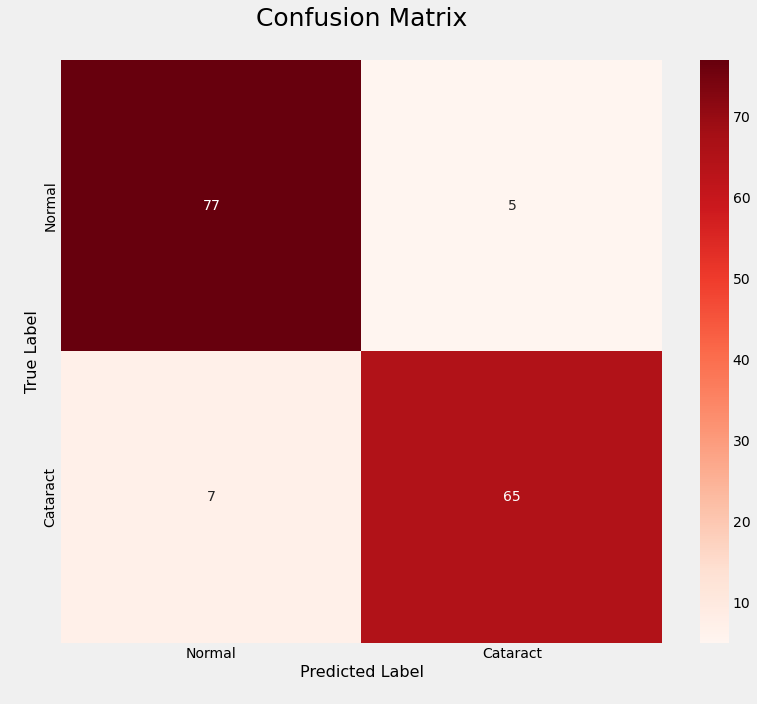

In [ ]:
# Confusion matrixi heatmap olarak bastırıyorum

# 142/154 = 0.9220 test accuracy

import seaborn as sns

classes = ["Normal","Cataract"]

plt.figure(figsize=(12,10))

sns.heatmap(cm, annot=True, cmap = plt.cm.Reds, fmt='d', 
            xticklabels=classes,
            yticklabels=classes)
plt.title('Confusion Matrix\n', fontsize=25)
plt.ylabel('\nTrue Label', fontsize=16)
plt.xlabel('Predicted Label\n', fontsize=16)
plt.show()